# Load libraries

In [ ]:
 #If using Google Colab, then run the following 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install tensorflow==2.11.0 keras==2.11.0 tensorflow-addons vit-keras tensorflow-hub

In [ ]:
####################################################################################################################

In [ ]:
#  If using Cloud Conda env, then run the following 

In [ ]:
!conda create -y -n myenv python=3.8

In [ ]:
conda init bash

In [ ]:
conda activate myenv

In [ ]:
!pip install tensorflow==2.11.0 keras==2.11.0 tensorflow-addons vit-keras tensorflow-hub

In [13]:
# Load libraries
import re
from typing import Dict, List, Optional, Text, Tuple
import matplotlib.pyplot as plt
from matplotlib import colors
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from typing import Callable, Tuple
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.python.keras.utils.losses_utils import reduce_weighted_loss



# Prepare data

In [14]:
"""Constants for the data reader."""

# INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
#                   'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']
INPUT_FEATURES = ['elevation', 'th', 'sph', 'pr', 'NDVI', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask', ]

# Data statistics
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, standard deviation)
DATA_STATS = {
    # Elevation in m.
    # 0.1 percentile, 99.9 percentile
    'elevation': (0.0, 3141.0, 657.3003, 649.0147),
    # Pressure
    # 0.1 percentile, 99.9 percentile
    'pdsi': (-6.12974870967865, 7.876040384292651, -0.0052714925, 2.6823447),
    'NDVI': (-9821.0, 9996.0, 5157.625, 2466.6677),  # min, max
    # Precipitation in mm.
    # Negative values do not make sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 44.53038024902344, 1.7398051, 4.482833),
    # Specific humidity.
    # Negative values do not make sense, so min is set to 0.
    # The range of specific humidity is up to 100% so max is 1.
    'sph': (0., 1., 0.0071658953, 0.0042835088),
    # Wind direction in degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th': (0., 360.0, 190.32976, 72.59854),
    # Min/max temperature in Kelvin.
    # -20 degree C, 99.9 percentile
    'tmmn': (253.15, 298.94891357421875, 281.08768, 8.982386),
    # -20 degree C, 99.9 percentile
    'tmmx': (253.15, 315.09228515625, 295.17383, 9.815496),
    # Wind speed in m/s.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs': (0.0, 10.024310074806237, 3.8500874, 1.4109988),
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc': (0.0, 106.24891662597656, 37.326267, 20.846027),
    # Population density
    # min, 99.9 percentile
    'population': (0., 2534.06298828125, 25.531384, 154.72331),
    # We don't want to normalize the FireMasks.
    # 1 indicates fire, 0 no fire, -1 unlabeled data
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
}

In [15]:
"""Library of common functions used in deep learning neural networks.
"""
def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Randomly axis-align crop input and output image tensors.

    Args:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
        sample_size: side length (square) to crop to.
        num_in_channels: number of channels in input_img.
        num_out_channels: number of channels in output_img.
    Returns:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
    """
    combined = tf.concat([input_img, output_img], axis=2)
    combined = tf.image.random_crop(
        combined,
        [sample_size, sample_size, num_in_channels + num_out_channels])
    input_img = combined[:, :, 0:num_in_channels]
    output_img = combined[:, :, -num_out_channels:]
    return input_img, output_img


def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Center crops input and output image tensors.

    Args:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
        sample_size: side length (square) to crop to.
    Returns:
        input_img: tensor with dimensions HWC.
        output_img: tensor with dimensions HWC.
    """
    central_fraction = sample_size / input_img.shape[0]
    input_img = tf.image.central_crop(input_img, central_fraction)
    output_img = tf.image.central_crop(output_img, central_fraction)
    return input_img, output_img

In [16]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
    """Extracts the base key from the provided key.

    Earth Engine exports TFRecords containing each data variable with its
    corresponding variable name. In the case of time sequences, the name of the
    data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
    where 'variable' is the name of the variable, and n the number of elements
    in the time sequence. Extracting the base key ensures that each step of the
    time sequence goes through the same normalization steps.
    The base key obeys the following naming pattern: '([a-zA-Z]+)'
    For instance, for an input key 'variable_1', this function returns 'variable'.
    For an input key 'variable', this function simply returns 'variable'.

    Args:
        key: Input key.

    Returns:
        The corresponding base key.

    Raises:
        ValueError when `key` does not match the expected pattern.
    """
    match = re.match(r'([a-zA-Z]+)', key)
    if match:
        return match.group(1)

    raise ValueError(
      'The provided key does not match the expected pattern: {}'.format(key))


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
    """Clips and rescales inputs with the stats corresponding to `key`.

    Args:
        inputs: Inputs to clip and rescale.
        key: Key describing the inputs.

    Returns:
        Clipped and rescaled input.

    Raises:
        ValueError if there are no data statistics available for `key`.
    """
    base_key = _get_base_key(key)
    if base_key not in DATA_STATS:
        raise ValueError(
            'No data statistics available for the requested key: {}.'.format(key))
    min_val, max_val, _, _ = DATA_STATS[base_key]
    inputs = tf.clip_by_value(inputs, min_val, max_val)
    return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
    """Clips and normalizes inputs with the stats corresponding to `key`.

    Args:
        inputs: Inputs to clip and normalize.
        key: Key describing the inputs.

    Returns:
        Clipped and normalized input.

    Raises:
        ValueError if there are no data statistics available for `key`.
    """
    base_key = _get_base_key(key)
    if base_key not in DATA_STATS:
        raise ValueError(
            'No data statistics available for the requested key: {}.'.format(key))
    min_val, max_val, mean, std = DATA_STATS[base_key]
    inputs = tf.clip_by_value(inputs, min_val, max_val)
    inputs = inputs - mean
    return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
    """Creates a features dictionary for TensorFlow IO.

    Args:
        sample_size: Size of the input tiles (square).
        features: List of feature names.

    Returns:
        A features dictionary for TensorFlow IO.
    """
    sample_shape = [sample_size, sample_size]
    features = set(features)
    columns = [
        tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
        for _ in features
    ]
    return dict(zip(features, columns))


def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Reads a serialized example.

    Args:
        example_proto: A TensorFlow example protobuf.
        data_size: Size of tiles (square) as read from input files.
        sample_size: Size the tiles (square) when input into the model.
        num_in_channels: Number of input channels.
        clip_and_normalize: True if the data should be clipped and normalized.
        clip_and_rescale: True if the data should be clipped and rescaled.
        random_crop: True if the data should be randomly cropped.
        center_crop: True if the data should be cropped in the center.

    Returns:
        (input_img, output_img) tuple of inputs and outputs to the ML model.
    """
    if (random_crop and center_crop):
        raise ValueError('Cannot have both random_crop and center_crop be True')
    input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
    feature_names = input_features + output_features
    features_dict = _get_features_dict(data_size, feature_names)
    features = tf.io.parse_single_example(example_proto, features_dict)

    if clip_and_normalize:
        inputs_list = [
            _clip_and_normalize(features.get(key), key) for key in input_features
        ]
    elif clip_and_rescale:
        inputs_list = [
            _clip_and_rescale(features.get(key), key) for key in input_features
        ]
    else:
        inputs_list = [features.get(key) for key in input_features]

    inputs_stacked = tf.stack(inputs_list, axis=0)
    input_img = tf.transpose(inputs_stacked, [1, 2, 0])

    outputs_list = [features.get(key) for key in output_features]
    assert outputs_list, 'outputs_list should not be empty'
    outputs_stacked = tf.stack(outputs_list, axis=0)

    outputs_stacked_shape = outputs_stacked.get_shape().as_list()
    assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
    output_img = tf.transpose(outputs_stacked, [1, 2, 0])

    if random_crop:
        input_img, output_img = random_crop_input_and_output_images(
            input_img, output_img, sample_size, num_in_channels, 1)
    if center_crop:
        input_img, output_img = center_crop_input_and_output_images(
            input_img, output_img, sample_size)
    return input_img, output_img


def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                batch_size: int, num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
    """Gets the dataset from the file pattern.

    Args:
        file_pattern: Input file pattern.
        data_size: Size of tiles (square) as read from input files.
        sample_size: Size the tiles (square) when input into the model.
        batch_size: Batch size.
        num_in_channels: Number of input channels.
        compression_type: Type of compression used for the input files.
        clip_and_normalize: True if the data should be clipped and normalized, False
          otherwise.
        clip_and_rescale: True if the data should be clipped and rescaled, False
          otherwise.
        random_crop: True if the data should be randomly cropped.
        center_crop: True if the data shoulde be cropped in the center.

    Returns:
        A TensorFlow dataset loaded from the input file pattern, with features
        described in the constants, and with the shapes determined from the input
        parameters to this function.
    """
    if (clip_and_normalize and clip_and_rescale):
        raise ValueError('Cannot have both normalize and rescale.')
    dataset = tf.data.Dataset.list_files(file_pattern)
    dataset = dataset.interleave(
        lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(
        lambda x: _parse_fn(  # pylint: disable=g-long-lambda
            x, data_size, sample_size, num_in_channels, clip_and_normalize,
            clip_and_rescale, random_crop, center_crop),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [17]:
BATCH_SIZE = 32

train_dataset = get_dataset('/home/liang.zhimi/ondemand/northamerica_2012-2023/train/*_ongoing_*.tfrecord',
    data_size=64, sample_size=32, batch_size=BATCH_SIZE,
    num_in_channels=6, compression_type=None, clip_and_normalize=True,
    clip_and_rescale=False, random_crop=True, center_crop=False)

validation_dataset = get_dataset('/home/liang.zhimi/ondemand/northamerica_2012-2023/val/*_ongoing_*.tfrecord',
    data_size=64, sample_size=32, batch_size=BATCH_SIZE,
    num_in_channels=6, compression_type=None, clip_and_normalize=True,
    clip_and_rescale=False, random_crop=True, center_crop=False)

test_dataset = get_dataset('/home/liang.zhimi/ondemand/northamerica_2012-2023/test/*_ongoing_*.tfrecord',
    data_size=64, sample_size=32, batch_size=BATCH_SIZE,
    num_in_channels=6, compression_type=None, clip_and_normalize=True,
    clip_and_rescale=False, random_crop=True, center_crop=False)

# Visualize data

In [ ]:
# TITLES = [
#   'Elevation',
#   'Wind\ndirection',
#   'Wind\nvelocity',
#   'Min\ntemp',
#   'Max\ntemp',
#   'Humidity',
#   'Precip',
#   'Drought',
#   'Vegetation',
#   'Population\ndensity',
#   'Energy\nrelease\ncomponent',
#   'Previous\nfire\nmask',
#   'Fire\nmask'
# ]
TITLES = [
'elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask'
]


In [ ]:
def plot_sample_from_dataset(dataset: tf.data.Dataset):
    """
    Plot one row of samples from the dataset showing 12 features and fire mask.

    Args:
        dataset (tf.data.Dataset): Dataset from which to plot samples.
    """
    global TITLES

    # Get a batch
    inputs, labels = None, None
    for elem in dataset:
        inputs, labels = elem
        break

    # Select the first sample
    sample_inputs = inputs[0]
    sample_label = labels[0]

    fig, axs = plt.subplots(1, 13, figsize=(25, 5))

    # Variables for controlling the color map for the fire masks
    CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
    BOUNDS = [-1, -0.1, 0.001, 1]
    NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

    for j in range(12):
        ax = axs[j]
        ax.imshow(sample_inputs[:, :, j], cmap='viridis')
        ax.set_title(TITLES[j], fontsize=13)
        ax.axis('off')
        # Add height and width annotations
        ax.text(0.5, -0.1, f'{sample_inputs.shape[0]}x{sample_inputs.shape[1]}', size=12, ha='center', transform=ax.transAxes)

    # Plot the fire mask
    ax = axs[12]
    ax.imshow(sample_label[:, :, 0], cmap=CMAP, norm=NORM)
    ax.set_title(TITLES[11], fontsize=13)
    ax.axis('off')
    # Add height and width annotations
    ax.text(0.5, -0.1, f'{sample_label.shape[0]}x{sample_label.shape[1]}', size=12, ha='center', transform=ax.transAxes)

    plt.tight_layout()
    plt.show()

# Example usage
plot_sample_from_dataset(train_dataset)

# Building testing

In [18]:
def IoU_metric(real_mask: tf.Tensor, predicted_mask: tf.Tensor) -> float:
    """
    Calculation of intersection over union metric.

    Args:
        real_mask (Tensor): Ground-truth mask
        predicted_mask (Tensor): Mask predicted by model
    Returns:
        (float): IoU metric value
    """
    real_mask = tf.where(real_mask < 0, 0, real_mask)

    intersection = np.logical_and(real_mask, predicted_mask)
    union = np.logical_or(real_mask, predicted_mask)

    if np.sum(union) == 0:
        return 1
    return np.sum(intersection) / np.sum(union)

def recall_metric(real_mask: tf.Tensor, predicted_mask: tf.Tensor) -> float:
    """
    Calculation of recall metric.

    Args:
        real_mask (Tensor): Ground-truth mask
        predicted_mask (Tensor): Mask predicted by model
    Returns:
        (float): recall metric value
    """
    real_mask = tf.where(real_mask < 0, 0, real_mask)

    true_positives = np.sum(np.logical_and(real_mask, predicted_mask))
    actual_positives = np.sum(real_mask)
    if actual_positives == 0:
        return 1

    return true_positives / actual_positives

def precision_metric(real_mask: tf.Tensor, predicted_mask: tf.Tensor) -> float:
    """
    Calculation of precision metric.

    Args:
        real_mask (Tensor): Ground-truth mask
        predicted_mask (Tensor): Mask predicted by model
    Returns:
        (float): precision metric value
    """
    real_mask = tf.where(real_mask < 0, 0, real_mask)

    true_positives = np.sum(np.logical_and(real_mask, predicted_mask))
    predicted_positives = np.sum(predicted_mask)
    if predicted_positives == 0:
        return 1

    return true_positives / predicted_positives

def f1_score(precision: float, recall: float) -> float:
    """
    Calculate the F1-score from precision and recall.
    
    Args:
        precision (float): The precision metric.
        recall (float): The recall metric.

    Returns:
        (float): The F1-score.
    """
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)


In [19]:
def dice_coef(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """
    Dice loss function calculator.

    Args:
        y_true (Tensor):
        y_pred (Tensor):
    Returns:
        (Tensor): Dice loss for each element of a batch.
    """
    smooth = 1e-6
    y_true_f = K.reshape(y_true, (BATCH_SIZE, -1))
    y_pred_f = K.reshape(y_pred, (BATCH_SIZE, -1))
    intersection = K.sum(y_true_f * y_pred_f, axis=1)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f, axis=1) + K.sum(y_pred_f, axis=1) + smooth)

def weighted_bincrossentropy(true: tf.Tensor, pred: tf.Tensor, weight_zero: float = 0.01, weight_one: float = 1) -> float:
    """
    Calculates weighted binary cross entropy. The weights are fixed.

    This can be useful for unbalanced catagories.

    Adjust the weights here depending on what is required.

    For example if there are 10x as many positive classes as negative classes,
        if you adjust weight_zero = 1.0, weight_one = 0.1, then false positives
        will be penalize 10 times as much as false negatives.

    Args:
        true (Tensor): Ground-truth values
        pred (Tensor): Predited values
        weight_zero (float): Weight of class 0 (no-fire)
        weight_one (float): Weight of class 1 (fire)

    """

    # calculate the binary cross entropy
    bin_crossentropy = K.binary_crossentropy(true, pred)

    # apply the weights
    weights = true * weight_one + (1. - true) * weight_zero
    weighted_bin_crossentropy = weights * bin_crossentropy

    return K.mean(weighted_bin_crossentropy, axis=1)

def bce_dice_loss(y_true: tf.Tensor, y_pred: tf.Tensor):
    """
    BCE loss function calculator.

    Args:
        y_true (Tensor):
        y_pred (Tensor):
    Returns:
        (Tensor): Mean BCE Dice loss over a batch.
    """

    y_true_f = K.reshape(y_true, (BATCH_SIZE, -1))
    y_pred_f = K.reshape(y_pred, (BATCH_SIZE, -1))
    return reduce_weighted_loss(weighted_bincrossentropy(y_true_f, y_pred_f) + dice_coef(y_true, y_pred))

In [20]:
def evaluate_model(prediction_function: Callable[[tf.Tensor], tf.Tensor],
                   eval_dataset: tf.data.Dataset) -> Tuple[float, float, float, float]:
    """
    Loads dataset according to file pattern and evaluates model's predictions on it.

    Parameters:
        model (Callable[[tf.Tensor], tf.Tensor]): Function for model inference.
        eval_dataset (tf.dataDataset): Dataset for evaluation.

    Returns:
        Tuple[float, float, float, float]: IoU score, recall score, precision score and mean loss.
    """
    IoU_measures = []
    recall_measures = []
    precision_measures = []
    losses = []

    for inputs, labels in tqdm(eval_dataset):
        # Prediction shape (N, W, H)
        predictions = prediction_function(inputs)
        for i in range(inputs.shape[0]):
            IoU_measures.append(IoU_metric(labels[i, :, :,  0], predictions[i, :, :]))
            recall_measures.append(recall_metric(labels[i, :, :,  0], predictions[i, :, :]))
            precision_measures.append(precision_metric(labels[i, :, :,  0], predictions[i, :, :]))
        labels_cleared = tf.where(labels < 0, 0, labels)
        losses.append(bce_dice_loss(labels_cleared, tf.expand_dims(tf.cast(predictions, tf.float32), axis=-1)))

    mean_IoU = np.mean(IoU_measures)
    mean_recall = np.mean(recall_measures)
    mean_precision = np.mean(precision_measures)
    mean_loss = np.mean(losses)
    mean_f1 = f1_score(mean_precision, mean_recall)
    return mean_IoU, mean_recall, mean_precision, mean_f1, mean_loss

# Attention Unet Model

In [21]:
def conv_block(x, filters, kernel_size=(3, 3), padding='same', strides=1, activation=True, layers=3):
    """
    Applies a series of convolutional layers with optional activation and batch normalization.

    Args:
        x (tf.Tensor): Input tensor to the block.
        filters (int): Number of filters for each convolutional layer.
        kernel_size (Tuple[int, int]): Size of the convolution kernel. Defaults to (3, 3).
        padding (str): Padding mode for the convolutional layers. Defaults to 'same'.
        strides (int): Stride length for the convolution. Defaults to 1.
        activation (bool): Whether to apply the ReLU activation after the convolution. Defaults to True.
        layers (int): Number of convolutional layers in the block. Defaults to 3.

    Returns:
        tf.Tensor: Output tensor after applying the convolutional block.
    """
    # Multiple convolutional layers
    for _ in range(layers):
        x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
        x = BatchNormalization()(x)
        if activation:
            x = Activation('relu')(x)
    return x

def attention_gate(skip_conn, gating_signal, inter_shape):
    """
    Applies an attention mechanism to focus on important regions in the feature maps.

    Args:
        skip_conn (tf.Tensor): Skip connection tensor from the encoder.
        gating_signal (tf.Tensor): Tensor from the decoder that guides attention.
        inter_shape (int): Intermediate shape for the attention mechanism.

    Returns:
        tf.Tensor: Output tensor after applying the attention gate.
    """
    # More complex attention mechanism
    theta = Conv2D(inter_shape * 2, (2, 2), strides=(2, 2), padding='same')(skip_conn)
    phi = Conv2D(inter_shape * 2, (1, 1), padding='same')(gating_signal)
    concat = Add()([theta, phi])
    act = Activation('relu')(concat)
    psi = Conv2D(1, (1, 1), padding='same')(act)
    sigmoid = Activation('sigmoid')(psi)
    upsampled = UpSampling2D(size=(2, 2), interpolation='bilinear')(sigmoid)
    out = Multiply()([upsampled, skip_conn])
    return out

def build_attention_unet(input_shape=(32, 32, 6), num_classes=1):
    """
    Constructs an Attention U-Net model for image segmentation.

    Args:
        input_shape (Tuple[int, int, int]): Shape of the input image tensor. Defaults to (32, 32, 6).
        num_classes (int): Number of output classes. Defaults to 1 for binary segmentation.

    Returns:
        Model: A Keras Model object representing the Attention U-Net architecture.
    """
    inputs = Input(input_shape)
    # Increased filters and added an extra layer in each conv block
    c1 = conv_block(inputs, 32, layers=3)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = conv_block(p1, 64, layers=3)
    p2 = MaxPooling2D((2, 2))(c2)
    bn = conv_block(p2, 128, layers=3)

    ag1 = attention_gate(c2, bn, 64)  # Increased intermediate shape
    up1 = concatenate([UpSampling2D(size=(2, 2))(bn), ag1])
    c3 = conv_block(up1, 64, layers=3)

    ag2 = attention_gate(c1, c3, 32)
    up2 = concatenate([UpSampling2D(size=(2, 2))(c3), ag2])
    c4 = conv_block(up2, 32, layers=3)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(c4)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create and summarize the mode
attention_unet_model = build_attention_unet()
attention_unet_model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 6)]  0           []                               
                                                                                                  
 conv2d_44 (Conv2D)             (None, 32, 32, 32)   1760        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_30 (BatchN  (None, 32, 32, 32)  128         ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_38 (Activation)     (None, 32, 32, 32)   0           ['batch_normalization_30[0]

# Train

In [ ]:
def train_model(model: Model, train_dataset: tf.data.Dataset, epochs:int=10) -> Tuple[List[float], List[float]]:
    """
    Trains a model using train dataset. (Save weights of model with best IoU)

    Args:
        model (Model): Model to train.
        train_dataset (Dataset): Training dataset.
        epochs (int): Number of epochs
    Returns:
        Tuple[List[float], List[float]]: Train losses and Validation losses
    """
    loss_fn = bce_dice_loss
    optimizer = tf.keras.optimizers.Adam()
    batch_losses = []
    val_losses = []
    best_IoU = 0.0

    for epoch in range(epochs):
        losses = []
        print(f'Epoch {epoch+1}/{epochs}')
        # Iterate through the dataset
        progress = tqdm(train_dataset)
        for images, masks in progress:
            with tf.GradientTape() as tape:
                # Forward pass
                predictions = model(images, training=True)
                label = tf.where(masks < 0, 0, masks)
                # Compute the loss
                loss = loss_fn(label, predictions)
                losses.append(loss.numpy())
                progress.set_postfix({'batch_loss': loss.numpy()})
            # Compute gradients
            gradients = tape.gradient(loss, model.trainable_variables)
            # Update the model's weights
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        # Evaluate model
        print("Evaluation...")
        IoU, recall, precision,mean_F1,val_loss = evaluate_model(lambda x: tf.where(model.predict(x) > 0.5, 1, 0)[:,:,:,0], validation_dataset)
        print("Validation set metrics:")
        print(f"Mean IoU: {IoU}\nMean precision: {precision}\nMean recall: {recall}\nMean F1: {mean_F1}\nValidation loss: {val_loss}\n")
        # Save best model
        if IoU > best_IoU:
            best_IoU = IoU
            model.save_weights("attentionUnet_6feature.h5")

        # Print the loss for monitoring
        print(f'Epoch: {epoch}, Train loss: {np.mean(losses)}')
        batch_losses.append(np.mean(losses))
        val_losses.append(val_loss)

    print(f"Best model IoU: {best_IoU}")
    return batch_losses, val_losses

# Set reproducability
tf.random.set_seed(1337)

segmentation_model = build_attention_unet()
train_losses, val_losses = train_model(segmentation_model, train_dataset, epochs=15)

# Plot loss functions

In [ ]:
# Plot loss functions
def plot_train_and_val_losses(train_losses, val_losses):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(train_losses)
    axs[0].set_title("train loss")

    axs[1].plot(val_losses)
    axs[1].set_title("validation loss")

    plt.show()
    plt.savefig("attentionUnet_6feature.png")

plot_train_and_val_losses(train_losses, val_losses)

# Testing

In [22]:
# Testing
# Load best model
segmentation_model = build_attention_unet()
segmentation_model.load_weights("attentionUnet_6feature.h5")

In [23]:
# Metrics on test set
print("Evaluation...")
print("Test set metrics:")
IoU, recall, precision, mean_F1,test_loss = evaluate_model(lambda x: tf.where(segmentation_model.predict(x) > 0.5, 1, 0)[:,:,:,0], test_dataset)
print(f"Mean IoU: {IoU}\nMean precision: {precision}\nMean recall: {recall}\nMean F1: {mean_F1}\nTest loss: {test_loss}")


0it [00:00, ?it/s]

Evaluation...
Test set metrics:
1/1 [==============================] - 1s 509ms/step


1it [00:00,  1.24it/s]

1/1 [==============================] - 0s 130ms/step


2it [00:01,  1.98it/s]

1/1 [==============================] - 0s 134ms/step


3it [00:01,  2.43it/s]

1/1 [==============================] - 0s 142ms/step


4it [00:01,  2.71it/s]

1/1 [==============================] - 0s 121ms/step


5it [00:01,  3.01it/s]

1/1 [==============================] - 0s 130ms/step


6it [00:02,  3.15it/s]

1/1 [==============================] - 0s 139ms/step


7it [00:02,  3.21it/s]

1/1 [==============================] - 0s 136ms/step


8it [00:02,  3.26it/s]

1/1 [==============================] - 0s 125ms/step


9it [00:03,  3.35it/s]

1/1 [==============================] - 0s 129ms/step


10it [00:03,  3.33it/s]

1/1 [==============================] - 0s 127ms/step


11it [00:03,  3.32it/s]

1/1 [==============================] - 0s 136ms/step


12it [00:04,  3.34it/s]

1/1 [==============================] - 0s 124ms/step


13it [00:04,  3.39it/s]

1/1 [==============================] - 0s 134ms/step


14it [00:04,  3.40it/s]

1/1 [==============================] - 0s 123ms/step


15it [00:04,  3.49it/s]

1/1 [==============================] - 0s 132ms/step


16it [00:05,  3.46it/s]

1/1 [==============================] - 0s 136ms/step


17it [00:05,  3.43it/s]

1/1 [==============================] - 0s 127ms/step


18it [00:05,  3.45it/s]

1/1 [==============================] - 0s 138ms/step


19it [00:06,  3.40it/s]

1/1 [==============================] - 0s 132ms/step


20it [00:06,  3.42it/s]

1/1 [==============================] - 0s 132ms/step


21it [00:06,  3.40it/s]

1/1 [==============================] - 0s 115ms/step


22it [00:07,  2.86it/s]

1/1 [==============================] - 0s 131ms/step


23it [00:07,  3.00it/s]

1/1 [==============================] - 0s 119ms/step


24it [00:07,  3.15it/s]

1/1 [==============================] - 0s 132ms/step


25it [00:08,  3.22it/s]

1/1 [==============================] - 0s 122ms/step


26it [00:08,  3.37it/s]

1/1 [==============================] - 0s 128ms/step


27it [00:08,  3.39it/s]

1/1 [==============================] - 0s 134ms/step


28it [00:08,  3.39it/s]

1/1 [==============================] - 0s 119ms/step


29it [00:09,  3.49it/s]

1/1 [==============================] - 0s 124ms/step


30it [00:09,  3.55it/s]

1/1 [==============================] - 0s 130ms/step


31it [00:09,  3.49it/s]

1/1 [==============================] - 0s 132ms/step


32it [00:09,  3.47it/s]

1/1 [==============================] - 0s 129ms/step


33it [00:10,  3.47it/s]

1/1 [==============================] - 0s 126ms/step


34it [00:10,  3.54it/s]

1/1 [==============================] - 0s 128ms/step


35it [00:10,  3.53it/s]

1/1 [==============================] - 0s 131ms/step


36it [00:11,  3.49it/s]

1/1 [==============================] - 0s 129ms/step


37it [00:11,  3.47it/s]

1/1 [==============================] - 0s 132ms/step


38it [00:11,  3.45it/s]

1/1 [==============================] - 0s 132ms/step


39it [00:11,  3.43it/s]

1/1 [==============================] - 0s 137ms/step


40it [00:12,  3.41it/s]

1/1 [==============================] - 0s 138ms/step


41it [00:12,  3.38it/s]

1/1 [==============================] - 0s 135ms/step


42it [00:12,  3.36it/s]

1/1 [==============================] - 0s 133ms/step


43it [00:13,  3.37it/s]

1/1 [==============================] - 0s 133ms/step


44it [00:13,  3.37it/s]

1/1 [==============================] - 0s 131ms/step


45it [00:13,  3.39it/s]

1/1 [==============================] - 0s 123ms/step


46it [00:14,  3.42it/s]

1/1 [==============================] - 0s 129ms/step


47it [00:14,  3.42it/s]

1/1 [==============================] - 0s 126ms/step


48it [00:14,  3.44it/s]

1/1 [==============================] - 0s 124ms/step


49it [00:14,  3.47it/s]

1/1 [==============================] - 0s 129ms/step


50it [00:15,  3.45it/s]

1/1 [==============================] - 0s 135ms/step


51it [00:15,  3.42it/s]

1/1 [==============================] - 0s 127ms/step


52it [00:15,  3.46it/s]

1/1 [==============================] - 0s 125ms/step


53it [00:16,  3.48it/s]

1/1 [==============================] - 0s 129ms/step


54it [00:16,  3.45it/s]

1/1 [==============================] - 0s 115ms/step


55it [00:16,  3.54it/s]

1/1 [==============================] - 0s 130ms/step


56it [00:16,  3.53it/s]

1/1 [==============================] - 0s 123ms/step


57it [00:17,  3.61it/s]

1/1 [==============================] - 0s 129ms/step


58it [00:17,  3.49it/s]

1/1 [==============================] - 0s 130ms/step


59it [00:17,  3.46it/s]

1/1 [==============================] - 0s 131ms/step


60it [00:18,  3.42it/s]

1/1 [==============================] - 0s 133ms/step


61it [00:18,  3.41it/s]

1/1 [==============================] - 0s 132ms/step


62it [00:18,  3.41it/s]

1/1 [==============================] - 0s 132ms/step


63it [00:19,  3.33it/s]

1/1 [==============================] - 0s 129ms/step


64it [00:19,  3.36it/s]

1/1 [==============================] - 0s 148ms/step


65it [00:19,  3.30it/s]

1/1 [==============================] - 0s 135ms/step


66it [00:19,  3.31it/s]

1/1 [==============================] - 0s 132ms/step


67it [00:20,  3.34it/s]

1/1 [==============================] - 0s 135ms/step


68it [00:20,  3.35it/s]

1/1 [==============================] - 0s 130ms/step


69it [00:20,  3.35it/s]

1/1 [==============================] - 0s 128ms/step


70it [00:21,  3.40it/s]

1/1 [==============================] - 0s 132ms/step


71it [00:21,  3.39it/s]

1/1 [==============================] - 0s 133ms/step


72it [00:21,  3.39it/s]

1/1 [==============================] - 0s 123ms/step


73it [00:21,  3.49it/s]

1/1 [==============================] - 0s 130ms/step


74it [00:22,  3.47it/s]

1/1 [==============================] - 0s 125ms/step


75it [00:22,  3.55it/s]

1/1 [==============================] - 0s 124ms/step


76it [00:22,  3.61it/s]

1/1 [==============================] - 0s 133ms/step


77it [00:23,  3.54it/s]

1/1 [==============================] - 0s 132ms/step


78it [00:23,  3.52it/s]

1/1 [==============================] - 0s 132ms/step


79it [00:23,  3.46it/s]

1/1 [==============================] - 0s 124ms/step


80it [00:23,  3.55it/s]

1/1 [==============================] - 0s 131ms/step


81it [00:24,  3.53it/s]

1/1 [==============================] - 0s 133ms/step


82it [00:24,  3.51it/s]

1/1 [==============================] - 0s 131ms/step


83it [00:24,  3.48it/s]

1/1 [==============================] - 0s 131ms/step


84it [00:25,  3.52it/s]

1/1 [==============================] - 0s 128ms/step


85it [00:25,  3.50it/s]

1/1 [==============================] - 0s 130ms/step


86it [00:25,  3.51it/s]

1/1 [==============================] - 0s 129ms/step


87it [00:25,  3.51it/s]

1/1 [==============================] - 0s 128ms/step


88it [00:26,  3.49it/s]

1/1 [==============================] - 0s 133ms/step


89it [00:26,  3.45it/s]

1/1 [==============================] - 0s 118ms/step


90it [00:26,  3.56it/s]

1/1 [==============================] - 0s 136ms/step


91it [00:27,  3.50it/s]

1/1 [==============================] - 0s 131ms/step


92it [00:27,  3.48it/s]

1/1 [==============================] - 0s 118ms/step


93it [00:27,  3.57it/s]

1/1 [==============================] - 0s 133ms/step


94it [00:27,  3.52it/s]

1/1 [==============================] - 0s 129ms/step


95it [00:28,  3.51it/s]

1/1 [==============================] - 0s 134ms/step


96it [00:28,  3.45it/s]

1/1 [==============================] - 0s 129ms/step


97it [00:28,  3.44it/s]

1/1 [==============================] - 0s 127ms/step


98it [00:29,  3.47it/s]

1/1 [==============================] - 0s 132ms/step


99it [00:29,  3.40it/s]

1/1 [==============================] - 0s 120ms/step


100it [00:29,  3.50it/s]

1/1 [==============================] - 0s 125ms/step


101it [00:29,  3.51it/s]

1/1 [==============================] - 0s 126ms/step


102it [00:30,  3.51it/s]

1/1 [==============================] - 0s 139ms/step


103it [00:30,  3.47it/s]

1/1 [==============================] - 0s 133ms/step


104it [00:30,  3.43it/s]

1/1 [==============================] - 0s 138ms/step


105it [00:31,  3.40it/s]

1/1 [==============================] - 0s 129ms/step


106it [00:31,  3.41it/s]

1/1 [==============================] - 0s 128ms/step


107it [00:31,  3.43it/s]

1/1 [==============================] - 0s 137ms/step


108it [00:32,  3.31it/s]

1/1 [==============================] - 0s 127ms/step


109it [00:32,  3.35it/s]

1/1 [==============================] - 0s 141ms/step


110it [00:32,  3.33it/s]

1/1 [==============================] - 0s 133ms/step


111it [00:32,  3.34it/s]

1/1 [==============================] - 0s 128ms/step


112it [00:33,  3.36it/s]

1/1 [==============================] - 0s 133ms/step


113it [00:33,  3.37it/s]

1/1 [==============================] - 0s 129ms/step


114it [00:33,  3.38it/s]

1/1 [==============================] - 0s 131ms/step


115it [00:34,  3.37it/s]

1/1 [==============================] - 0s 130ms/step


116it [00:34,  3.40it/s]

1/1 [==============================] - 0s 136ms/step


117it [00:34,  3.37it/s]

1/1 [==============================] - 0s 132ms/step


118it [00:35,  3.28it/s]

1/1 [==============================] - 0s 130ms/step


119it [00:35,  3.32it/s]

1/1 [==============================] - 0s 140ms/step


120it [00:35,  3.33it/s]

1/1 [==============================] - 0s 131ms/step


121it [00:35,  3.36it/s]

1/1 [==============================] - 0s 133ms/step


122it [00:36,  3.39it/s]

1/1 [==============================] - 0s 120ms/step


123it [00:36,  3.51it/s]

1/1 [==============================] - 0s 131ms/step


124it [00:36,  3.48it/s]

1/1 [==============================] - 0s 137ms/step


125it [00:37,  3.42it/s]

1/1 [==============================] - 0s 149ms/step


126it [00:37,  3.37it/s]

1/1 [==============================] - 0s 142ms/step


127it [00:37,  3.38it/s]

1/1 [==============================] - 0s 143ms/step


128it [00:37,  3.32it/s]

1/1 [==============================] - 0s 146ms/step


129it [00:38,  3.33it/s]

1/1 [==============================] - 0s 143ms/step


130it [00:38,  3.35it/s]

1/1 [==============================] - 0s 133ms/step


131it [00:38,  3.46it/s]

1/1 [==============================] - 0s 129ms/step


132it [00:39,  3.49it/s]

1/1 [==============================] - 0s 140ms/step


133it [00:39,  3.47it/s]

1/1 [==============================] - 0s 128ms/step


134it [00:39,  3.50it/s]

1/1 [==============================] - 0s 145ms/step


135it [00:39,  3.45it/s]

1/1 [==============================] - 0s 149ms/step


136it [00:40,  3.43it/s]

1/1 [==============================] - 0s 147ms/step


137it [00:40,  3.40it/s]

1/1 [==============================] - 0s 138ms/step


138it [00:40,  3.40it/s]

1/1 [==============================] - 0s 138ms/step


139it [00:41,  3.42it/s]

1/1 [==============================] - 0s 140ms/step


140it [00:41,  3.40it/s]

1/1 [==============================] - 0s 145ms/step


141it [00:41,  3.40it/s]

1/1 [==============================] - 0s 127ms/step


142it [00:42,  3.45it/s]

1/1 [==============================] - 0s 129ms/step


143it [00:42,  3.47it/s]

1/1 [==============================] - 0s 128ms/step


144it [00:42,  3.47it/s]

1/1 [==============================] - 0s 127ms/step


145it [00:42,  3.45it/s]

1/1 [==============================] - 0s 130ms/step


146it [00:43,  3.46it/s]

1/1 [==============================] - 0s 132ms/step


147it [00:43,  3.45it/s]

1/1 [==============================] - 0s 131ms/step


148it [00:43,  3.44it/s]

1/1 [==============================] - 0s 132ms/step


149it [00:44,  3.43it/s]

1/1 [==============================] - 0s 133ms/step


150it [00:44,  3.41it/s]

1/1 [==============================] - 0s 136ms/step


151it [00:44,  3.38it/s]

1/1 [==============================] - 0s 133ms/step


152it [00:44,  3.37it/s]

1/1 [==============================] - 0s 132ms/step


153it [00:45,  3.39it/s]

1/1 [==============================] - 0s 132ms/step


154it [00:45,  3.42it/s]

1/1 [==============================] - 0s 137ms/step


155it [00:45,  3.40it/s]

1/1 [==============================] - 0s 131ms/step


156it [00:46,  3.40it/s]

1/1 [==============================] - 0s 126ms/step


157it [00:46,  3.45it/s]

1/1 [==============================] - 0s 120ms/step


158it [00:46,  3.54it/s]

1/1 [==============================] - 0s 120ms/step


159it [00:46,  3.60it/s]

1/1 [==============================] - 0s 129ms/step


160it [00:47,  3.62it/s]

1/1 [==============================] - 0s 103ms/step


161it [00:47,  3.79it/s]

1/1 [==============================] - 0s 127ms/step


162it [00:47,  3.67it/s]

1/1 [==============================] - 0s 139ms/step


163it [00:48,  3.55it/s]

1/1 [==============================] - 0s 126ms/step


164it [00:48,  3.48it/s]

1/1 [==============================] - 0s 125ms/step


165it [00:48,  3.50it/s]

1/1 [==============================] - 0s 133ms/step


166it [00:48,  3.46it/s]

1/1 [==============================] - 0s 132ms/step


167it [00:49,  3.42it/s]

1/1 [==============================] - 0s 134ms/step


168it [00:49,  3.39it/s]

1/1 [==============================] - 0s 126ms/step


169it [00:49,  3.44it/s]

1/1 [==============================] - 0s 128ms/step


170it [00:50,  3.43it/s]

1/1 [==============================] - 0s 122ms/step


171it [00:50,  3.53it/s]

1/1 [==============================] - 0s 123ms/step


172it [00:50,  3.60it/s]

1/1 [==============================] - 0s 130ms/step


173it [00:50,  3.55it/s]

1/1 [==============================] - 0s 131ms/step


174it [00:51,  3.52it/s]

1/1 [==============================] - 0s 131ms/step


175it [00:51,  3.50it/s]

1/1 [==============================] - 0s 136ms/step


176it [00:51,  3.44it/s]

1/1 [==============================] - 0s 132ms/step


177it [00:52,  3.41it/s]

1/1 [==============================] - 0s 127ms/step


178it [00:52,  3.42it/s]

1/1 [==============================] - 0s 133ms/step


179it [00:52,  3.39it/s]

1/1 [==============================] - 0s 124ms/step


180it [00:52,  3.42it/s]

1/1 [==============================] - 0s 126ms/step


181it [00:53,  3.43it/s]

1/1 [==============================] - 0s 135ms/step


182it [00:53,  3.42it/s]

1/1 [==============================] - 0s 134ms/step


183it [00:53,  3.40it/s]

1/1 [==============================] - 0s 133ms/step


184it [00:54,  3.38it/s]

1/1 [==============================] - 0s 124ms/step


185it [00:54,  3.42it/s]

1/1 [==============================] - 0s 132ms/step


186it [00:54,  3.42it/s]

1/1 [==============================] - 0s 134ms/step


187it [00:55,  3.36it/s]

1/1 [==============================] - 0s 131ms/step


188it [00:55,  3.38it/s]

1/1 [==============================] - 0s 134ms/step


189it [00:55,  3.39it/s]

1/1 [==============================] - 0s 122ms/step


190it [00:55,  3.51it/s]

1/1 [==============================] - 0s 118ms/step


191it [00:56,  3.59it/s]

1/1 [==============================] - 0s 129ms/step


192it [00:56,  3.56it/s]

1/1 [==============================] - 0s 129ms/step


193it [00:56,  3.51it/s]

1/1 [==============================] - 0s 136ms/step


194it [00:57,  3.46it/s]

1/1 [==============================] - 0s 129ms/step


195it [00:57,  3.45it/s]

1/1 [==============================] - 0s 129ms/step


196it [00:57,  3.44it/s]

1/1 [==============================] - 0s 132ms/step


197it [00:57,  3.38it/s]

1/1 [==============================] - 0s 135ms/step


198it [00:58,  3.37it/s]

1/1 [==============================] - 0s 138ms/step


199it [00:58,  3.35it/s]

1/1 [==============================] - 0s 126ms/step


200it [00:58,  3.46it/s]

1/1 [==============================] - 0s 128ms/step


201it [00:59,  3.45it/s]

1/1 [==============================] - 0s 122ms/step


202it [00:59,  3.57it/s]

1/1 [==============================] - 0s 115ms/step


203it [00:59,  3.70it/s]

1/1 [==============================] - 0s 117ms/step


204it [00:59,  3.75it/s]

1/1 [==============================] - 0s 131ms/step


205it [01:00,  3.62it/s]

1/1 [==============================] - 0s 130ms/step


206it [01:00,  3.53it/s]

1/1 [==============================] - 0s 120ms/step


207it [01:00,  3.59it/s]

1/1 [==============================] - 0s 134ms/step


208it [01:00,  3.52it/s]

1/1 [==============================] - 0s 128ms/step


209it [01:01,  3.51it/s]

1/1 [==============================] - 0s 135ms/step


210it [01:01,  3.53it/s]

1/1 [==============================] - 0s 134ms/step


211it [01:01,  3.48it/s]

1/1 [==============================] - 0s 129ms/step


212it [01:02,  3.45it/s]

1/1 [==============================] - 0s 130ms/step


213it [01:02,  3.44it/s]

1/1 [==============================] - 0s 130ms/step


214it [01:02,  3.43it/s]

1/1 [==============================] - 0s 136ms/step


215it [01:03,  3.38it/s]

1/1 [==============================] - 0s 125ms/step


216it [01:03,  3.38it/s]

1/1 [==============================] - 0s 124ms/step


217it [01:03,  3.45it/s]

1/1 [==============================] - 0s 130ms/step


218it [01:03,  3.45it/s]

1/1 [==============================] - 0s 131ms/step


219it [01:04,  3.44it/s]

1/1 [==============================] - 0s 138ms/step


220it [01:04,  3.39it/s]

1/1 [==============================] - 0s 126ms/step


221it [01:04,  3.41it/s]

1/1 [==============================] - 0s 126ms/step


222it [01:05,  3.45it/s]

1/1 [==============================] - 0s 128ms/step


223it [01:05,  3.43it/s]

1/1 [==============================] - 0s 130ms/step


224it [01:05,  3.43it/s]

1/1 [==============================] - 0s 133ms/step


225it [01:05,  3.38it/s]

1/1 [==============================] - 0s 131ms/step


226it [01:06,  3.37it/s]

1/1 [==============================] - 0s 131ms/step


227it [01:06,  3.39it/s]

1/1 [==============================] - 0s 131ms/step


228it [01:06,  3.39it/s]

1/1 [==============================] - 0s 122ms/step


229it [01:07,  3.47it/s]

1/1 [==============================] - 0s 121ms/step


230it [01:07,  3.55it/s]

1/1 [==============================] - 0s 123ms/step


231it [01:07,  3.60it/s]

1/1 [==============================] - 0s 129ms/step


232it [01:07,  3.56it/s]

1/1 [==============================] - 0s 128ms/step


233it [01:08,  3.50it/s]

1/1 [==============================] - 0s 140ms/step


234it [01:08,  3.44it/s]

1/1 [==============================] - 0s 129ms/step


235it [01:08,  3.44it/s]

1/1 [==============================] - 0s 129ms/step


236it [01:09,  3.43it/s]

1/1 [==============================] - 0s 129ms/step


237it [01:09,  3.43it/s]

1/1 [==============================] - 0s 127ms/step


238it [01:09,  3.42it/s]

1/1 [==============================] - 0s 143ms/step


239it [01:10,  3.33it/s]

1/1 [==============================] - 0s 127ms/step


240it [01:10,  3.37it/s]

1/1 [==============================] - 0s 132ms/step


241it [01:10,  3.39it/s]

1/1 [==============================] - 0s 130ms/step


242it [01:10,  3.37it/s]

1/1 [==============================] - 0s 133ms/step


243it [01:11,  3.37it/s]

1/1 [==============================] - 0s 135ms/step


244it [01:11,  3.37it/s]

1/1 [==============================] - 0s 130ms/step


245it [01:11,  3.39it/s]

1/1 [==============================] - 0s 143ms/step


246it [01:12,  3.34it/s]

1/1 [==============================] - 0s 130ms/step


247it [01:12,  3.35it/s]

1/1 [==============================] - 0s 133ms/step


248it [01:12,  3.35it/s]

1/1 [==============================] - 0s 134ms/step


249it [01:13,  3.33it/s]

1/1 [==============================] - 0s 127ms/step


250it [01:13,  3.37it/s]

1/1 [==============================] - 0s 126ms/step


251it [01:13,  3.42it/s]

1/1 [==============================] - 0s 131ms/step


252it [01:13,  3.40it/s]

1/1 [==============================] - 0s 134ms/step


253it [01:14,  3.39it/s]

1/1 [==============================] - 0s 128ms/step


254it [01:14,  3.40it/s]

1/1 [==============================] - 0s 135ms/step


255it [01:14,  3.37it/s]

1/1 [==============================] - 0s 144ms/step


256it [01:15,  3.33it/s]

1/1 [==============================] - 1s 518ms/step


257it [01:15,  3.39it/s]

Mean IoU: 0.17798400061926167
Mean precision: 0.4650301586429736
Mean recall: 0.4211397040601115
Mean F1: 0.44199802234878416
Test loss: 0.965255618095398


# Inference on test set

1/1 [==============================] - 0s 130ms/step
Features shape: (32, 32, 32, 6)
Label shape: (32, 32, 32, 1)
Prediction shape: (32, 32, 32)
Example true labels (sample 0):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Example predicted labels (sample 0):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


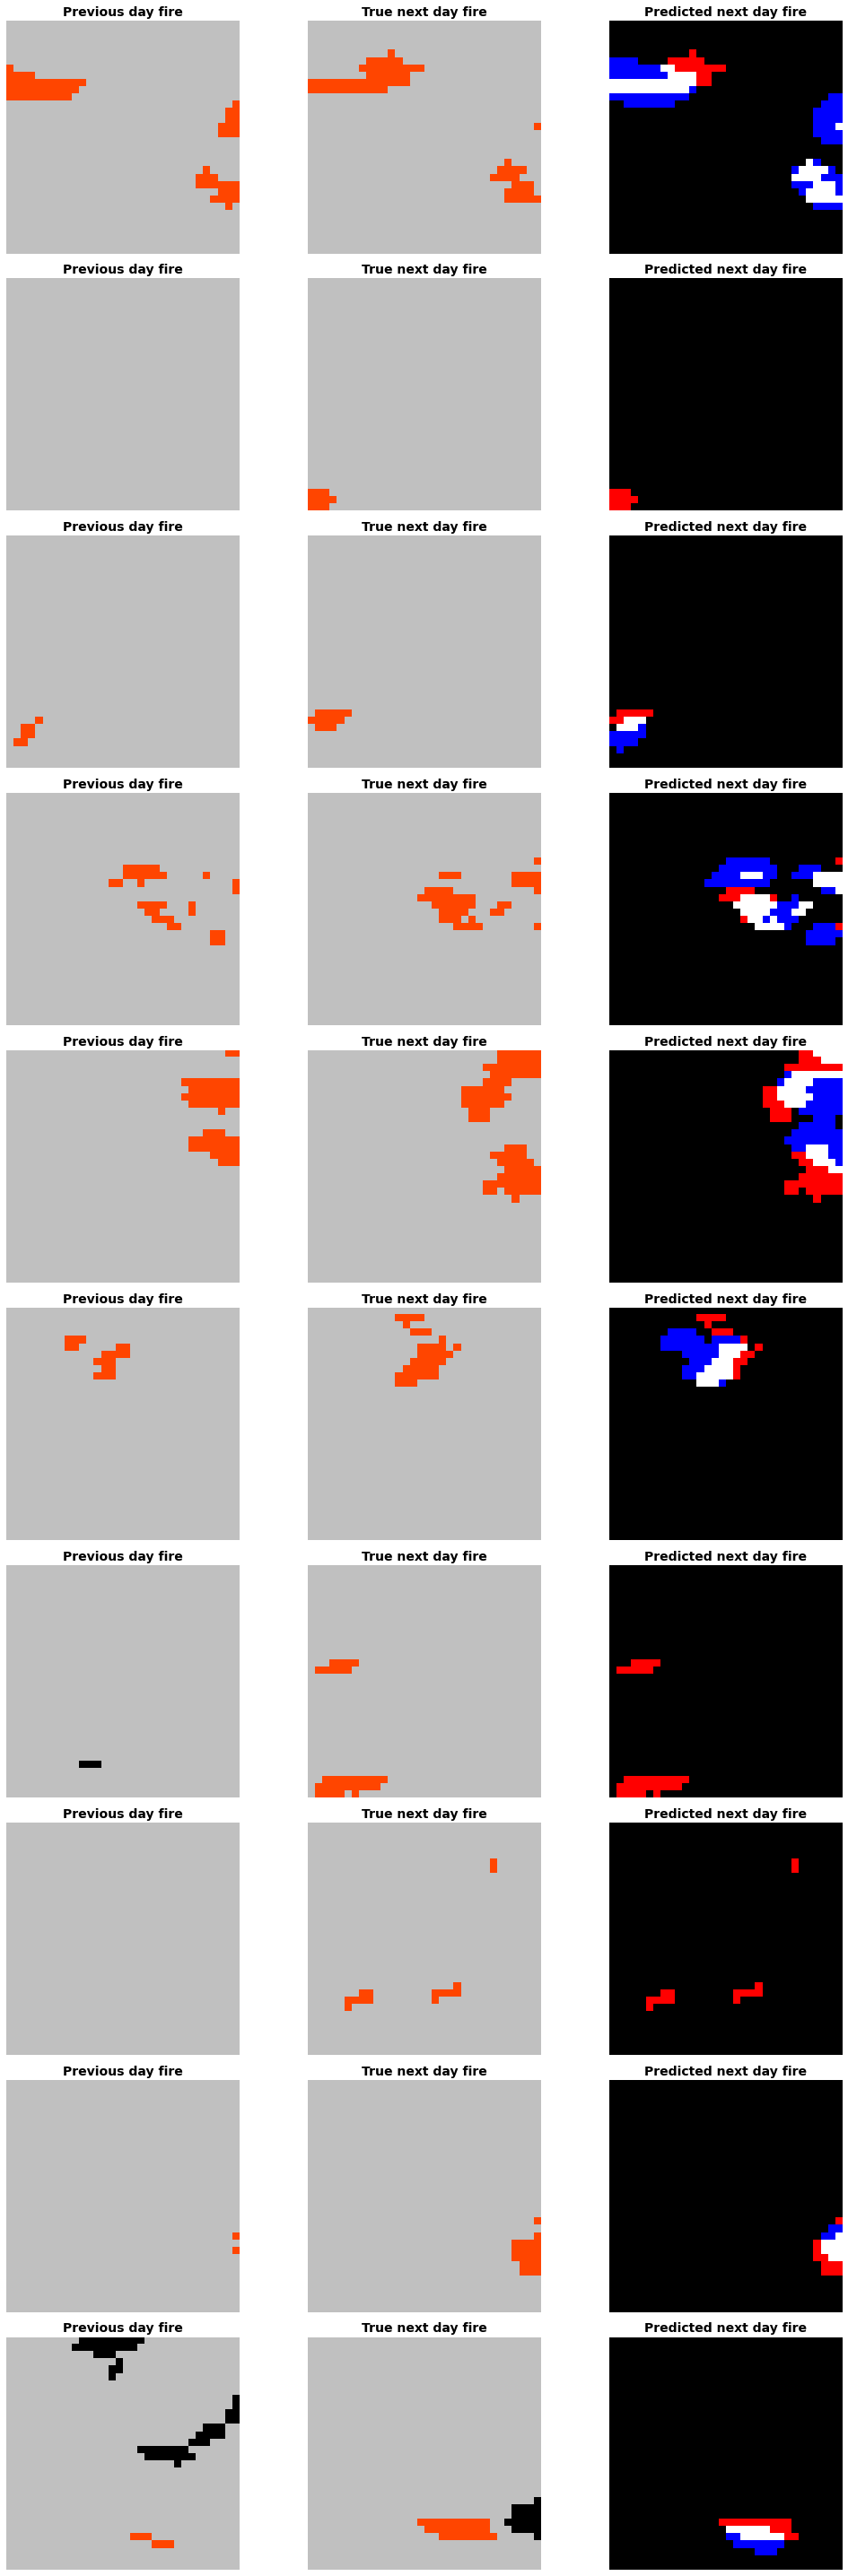

In [24]:
# Inference on test set
def show_inference(n_rows: int, features: tf.Tensor, label: tf.Tensor, prediction_function: Callable[[tf.Tensor], tf.Tensor]) -> None:
    """
    Show model inference through images.

    Args:
        n_rows (int): Number of rows for subplots.
        features (tf.Tensor): Input features.
        label (tf.Tensor): True labels.
        prediction_function (Callable[[tf.Tensor], tf.Tensor]): Function for model prediction.
    """

    # Variables for controlling the color map for the fire masks
    CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
    BOUNDS = [-1, -0.1, 0.001, 1]
    NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

    fig = plt.figure(figsize=(15, n_rows*4))

    prediction = prediction_function(features)


    # print shape info
    print(f"Features shape: {features.shape}")
    print(f"Label shape: {label.shape}")
    print(f"Prediction shape: {prediction.shape}")

    # Print some of the true and predicted labels of the first sample as a validation
    print(f"Example true labels (sample 0):\n{label[0, :, :, 0]}")
    print(f"Example predicted labels (sample 0):\n{prediction[0, :, :]}")


    for i in range(n_rows):
        plt.subplot(n_rows, 3, i*3 + 1)
        plt.title("Previous day fire", fontdict={'fontsize': 14, 'fontweight': 'bold'})
        plt.imshow(features[i, :, :, -1], cmap=CMAP, norm=NORM)
        plt.axis('off')

        plt.subplot(n_rows, 3, i*3 + 2)
        plt.title("True next day fire", fontdict={'fontsize': 14, 'fontweight': 'bold'})
        plt.imshow(label[i, :, :, 0], cmap=CMAP, norm=NORM)
        plt.axis('off')

        plt.subplot(n_rows, 3, i*3 + 3)
        plt.title("Predicted next day fire", fontdict={'fontsize': 14, 'fontweight': 'bold'})
        # plt.imshow(prediction[i, :, :])
        true_labels = label[i, :, :, 0]  # Shape: (height, width)
        predicted_labels = prediction[i, :, :]  # Shape: (height, width)

        # Create an image to show TP, FP, and FN
        tp = np.logical_and(predicted_labels == 1, true_labels == 1)
        fp = np.logical_and(predicted_labels == 1, true_labels == 0)
        fn = np.logical_and(predicted_labels == 0, true_labels == 1)

        result = np.zeros((true_labels.shape[0], true_labels.shape[1], 3))

        # Set colors:
        result[tp] = [1, 1, 1]  # White for True Positives
        result[fp] = [0, 0, 1]  # Blue for False Positives
        result[fn] = [1, 0, 0]  # Red for False Negatives

        plt.imshow(result)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig("AttentionUnet_Inference.png")

features, labels = next(iter(test_dataset))
show_inference(10, features, labels, lambda x: tf.where(segmentation_model.predict(x) > 0.5, 1, 0)[:,:,:,0])